In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Measurement-based quantum computation {#mbqc}

----

*Authors: Joost Bus and Radoica Draškić --- Posted: 05 December 2022.
Last updated: 05 December 2022.*


**Measurement-based quantum computing (MBQC)**, also known as one-way
quantum computing, is an inventive approach to quantum computing that
makes use of *off-line* entanglement as a resource for computation. A
one-way quantum computer starts out with an entangled state, a so-called
*cluster state*, and applies particular single-qubit measurements that
correspond to the desired quantum circuit. In this context, off-line
means that the entanglement is created independently from the rest of
the computation, like how a blank sheet of paper is made separately from
the text of a book. Coming from the gate-based model, this method might
seem unintuitive to you at first, but the approaches can be proven to be
equally powerful. In MBQC, the measurements *are* the computation and
the entanglement of the cluster state is used as a resource.

The structure of this demo will be as follows. First, we introduce the
concept of a cluster state, the substrate for measurement-based quantum
computation. Then, we will move on to explain how to implement arbitrary
quantum circuits, thus proving that MBQC is universal. Lastly, we will
briefly touch upon how quantum error correction (QEC) is done in this
scheme.

Throughout this tutorial, we will explain the underlying concepts with
the help of some code snippets using
[PennyLane](https://pennylane.readthedocs.io/en/stable/). In the section
about QEC, we will also use Xanadu\'s quantum error correction
simulation software
[FlamingPy](https://flamingpy.readthedocs.io/en/latest/) developed by
our architecture team.

In MBQC, seeing is computing!

![](.graphics/2023-05-02-18-36-13.png)


## Cluster states and graph states

*Cluster states* are the universal substrate for measurement-based
quantum computation . They are a special instance of *graph states*, a
class of entangled multi-qubit states that can be represented by an
undirected graph $G = (V,E)$ whose vertices $V$ are associated with
qubits and the edges $E$ with entanglement between them. The associated
quantum state reads as follows

$$
| \Phi \rangle = \Pi_{(i, j) \in E} \, CZ_{ij}|+⟩^{\otimes n}
$$

where $n$ is the number of qubits, $CZ_{ij}$ is the controlled-$Z$ gate
between qubits $i$ and $j$, and
$|+\rangle = \frac{1}{\sqrt{2}} \big( |0\rangle + |1\rangle \big)$ is the
$+1$ eigenstate of the Pauli-$X$ operator. The
distinction between graph states and a cluster states is rather
technical and details can be found in Ref. [21]. For now, suffice to say
that cluster states are a subset of graph states with some additional
conditions.

We can also describe the creation of a cluster state in the gate-based
model. Let us first define a graph we want to look at, and then
construct a circuit in PennyLane to create the corresponding graph
state.


TODO: Add the difference between graph states and cluster states. (From ref 21 maybe?)

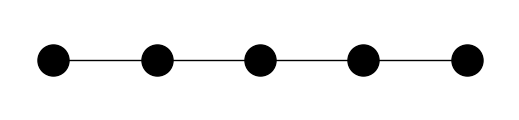

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

a, b = 1, 5  # dimensions of the graph (lattice)
G = nx.grid_graph(dim=[a, b])  # there are a * b qubits

plt.figure(figsize=(5, 1))
nx.draw(G, pos={node: node for node in G}, node_size=500, node_color="black")

This is a fairly simple cluster state, but we will later see how even
this simple graph is useful for logical operations. Now that we have
defined a graph, we can go ahead and define a circuit to prepare the
cluster state.


In [2]:
import pennylane as qml

qubits = [str(node) for node in G.nodes]
dev = qml.device("default.qubit", wires=qubits)

In [3]:
qubits

['(0, 0)', '(1, 0)', '(2, 0)', '(3, 0)', '(4, 0)']

(<Figure size 800x600 with 1 Axes>, <Axes: >)


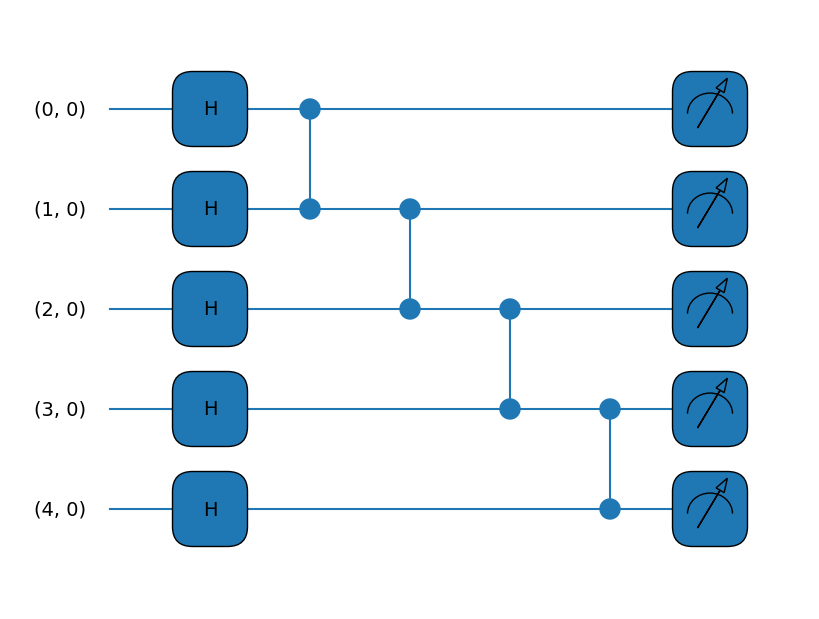

In [7]:
@qml.qnode(dev, interface="autograd")
def cluster_state():
    for node in qubits:
        qml.Hadamard(wires=[node])

    for edge in G.edges:
        i, j = edge
        qml.CZ(wires=[str(i), str(j)])

    return qml.state()


print(qml.draw_mpl(cluster_state, output="mpl")())

Observe that the structure of the circuit is fairly simple. It only
requires Hadamard gates on each qubit and then a controlled-$Z$ gate
between connected qubits. This part of the computation is not actually
computing anything. In fact, aside from the width and depth of the
desired quantum circuit, the cluster state generation is essentially
independent of the calculation. If you have a reliable way of applying
these two operations (Hadamard and controlled-$Z$), you are ready for
the next step: worrying about conditional single-qubit measurements.


## Information propagation and teleportation

Measurement-based quantum computation heavily relies on the idea of
information propagation. In particular, we make use of a protocol called
*quantum teleportation*, one of the driving concepts behind MBQC.
Despite its Sci-Fi name, quantum teleportation is very real and has been
experimentally demonstrated multiple times in the last few decades ,,,.
Moreover, it has related applications in safe communication protocols
that are impossible with classical communication so it\'s certainly
worth learning about. In this protocol, we transport *information*, not
matter, between systems. Admittedly, it has a somewhat misleading name
because it is not instantaneous: it requires communication of additional
classical information, which is still limited by the speed of light.

### One-qubit Teleportation 
Let's take a deeper look at the
principles behind quantum teleportation using a simple example of
one-qubit teleportation. We start with one qubit in the state
$\ket{\psi}$ that we want to transfer to the second
qubit initially in the state $|0\rangle$. The figure below represents
the protocol. The green box represents the creation of a cluster state,
while the red box represents the measurement of a qubit with the
appropriate correction applied to the second qubit based on the
measurement outcome.

![](.graphics/2023-05-02-18-37-05.png)

Let\'s implement one-qubit teleportation in PennyLane.


In [8]:
import pennylane as qml
import pennylane.numpy as np

dev = qml.device("default.qubit", wires=2)


@qml.qnode(dev, interface="autograd")
def one_bit_teleportation(input_state):
    # Prepare the input state from the incoming array of amplitude values
    qml.QubitStateVector(input_state, wires=0)

    # Prepare the cluster state for doing MBQC
    qml.Hadamard(wires=1)
    qml.CZ(wires=[0, 1])

    # Measure the first qubit in the Pauli-X basis
    # and apply an X-gate conditioned on the outcome
    qml.Hadamard(wires=0)
    m = qml.measure(wires=[0])
    qml.cond(m == 1, qml.PauliX)(wires=1)
    qml.Hadamard(wires=1)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[1])

Note that we return a [density
matrix](https://en.wikipedia.org/wiki/Density_matrix) in the function
above. This allows for us to describe operations beyond unitaries, such
as the teleportation protocol.

Now, let\'s prepare a random qubit state and see if the teleportation
protocol is working as expected. To do so, we\'ll generate a random
normalized state $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$ and
apply the teleportation protocol to see if the resulting density matrix
describing the second qubit is the same as our input state
$|\psi\rangle$.


In [15]:
def ket_bra(ket: np.array):
    """Computes the outer product of a ket vector with itself."""
    return np.outer(ket, np.conj(ket))

# Define helper function for random input state on n qubits
def generate_random_state(n=1):
    input_state = (1 + 1j) * np.random.random(2 ** n)
    return input_state / np.linalg.norm(input_state)

In [16]:
# Generate a random input state |psi> for n=1 qubit
input_state = generate_random_state()

density_matrix = ket_bra(input_state)
density_matrix_mbqc = one_bit_teleportation(input_state)

np.allclose(density_matrix, density_matrix_mbqc)

True

As we can see, $|\psi\rangle$, originally the state of the first qubit,
has been transported to the second qubit!

This protocol is one of the main ingredients of one-way quantum
computing. Essentially, we propagate the information in one end of our
cluster state to the other end through successive teleportations. In
addition, we can \"write\" our circuit onto the cluster state by
choosing the measurements adaptively. In the next section, we will see
how we can actually do this.


Universality of MBQC
====================

How do we know if this measurement-based scheme is just as powerful as
its gate-based counterpart? We have to prove it! In particular, we want
to show that a measurement-based quantum computer is a [quantum Turing
machine (QTM)](https://en.wikipedia.org/wiki/Quantum_Turing_machine). To
do this, we need to show 4 things:

1.  How **information propagates** through the cluster state.
2.  How arbitrary **single-qubit rotations** can be implemented.
3.  How a **two-qubit gate** can be implemented in this scheme.
4.  How to implement **arbitrary quantum circuits**.

In the previous section, we have already seen how the quantum
information propagates from one side of the cluster to the other. In
this section, we will tackle the remaining parts concerning logical
operations. Throughout, we will assume the ability to measure in
arbitrary bases.


Single-qubit rotations
======================

Arbitrary single-qubit rotations are essential operations for a
universal quantum computer. In MBQC, we can implement these rotations by
using the entanglement of the cluster state. Any single-qubit gate can
be represented as a composition of three rotations along two different
axes, for example
$U(\alpha, \beta, \gamma) = R_x(\gamma)R_z(\beta)R_x(\alpha)$ where
$R_x$ and $R_z$ represent rotations around the $X$ and $Z$ axis,
respectively.

We will see that in our measurement-based scheme, this operation can be
implemented using a linear chain of 5 qubits prepared in a cluster
state, as shown in the figure below. The first qubit $t_\mathrm{in}$ is
prepared in some input state $|\psi_\mathrm{in}\rangle$, and we are
interested in the final state of the output qubit $t_\mathrm{out}$.

![..](../demonstrations/mbqc/single-qubit-rotation.png){.align-center
width="75.0%"}

The input qubit $t_\mathrm{in}$, together with the intermediate qubits
$a_1$, $a_2$, and $a_3$ are then measured in the bases

$$\mathcal{B}_j(\theta_j) \equiv \left\{\frac{|0\rangle + e^{i\theta_j}|1\rangle}{\sqrt{2}},
\frac{|0\rangle - e^{i\theta_j}|1\rangle}{\sqrt{2}}\right\},$$

where the angles $\theta_j$ depend on prior measurement outcomes and are
given by

$$\theta_{\mathrm{in}} = 0, \qquad \theta_{1} = (-1)^{m_{\mathrm{in}} + 1} \alpha, \qquad
\theta_{2} = (-1)^{m_1} \beta, \quad \text{and} \quad \theta_{3} = (-1)^{m_{\mathrm{in}} + m_2} \gamma$$

with $m_{\mathrm{in}}, m_1, m_2 \in \{0, 1\}$ being the measurement
outcomes on nodes $t_\mathrm{in}$, $a_1$ and $a_2$, respectively. Note
that the measurement basis is adaptive; the measurement on $a_3$, for
example, depends on the outcome of earlier measurements in the chain.
After these operations, the state of qubit $t_\mathrm{out}$ is given by

$$|\psi_{\mathrm{out}}\rangle = \tilde{U}(\alpha, \beta, \gamma)|\psi_{\mathrm{in}}\rangle
= X^{m_1 + m_3}Z^{m_{\mathrm{in}} + m_2}U(\alpha, \beta, \gamma)
|\psi_{\mathrm{in}}\rangle.$$

with $m_3$ being the measurement outcome on node $a_3$. Now note that
this unitary $\tilde{U}$ is related to our desired unitary $U$ up to the
first two Pauli terms. Luckily, we can correct for these additional
Pauli gates by choosing the measurement basis of qubit $t_\mathrm{out}$
appropriately or correcting for them classically after the quantum
computation.

To demonstrate that this actually works, we will use PennyLane. For
simplicity, we will just show the ability will to perform single-axis
rotations $R_z(\theta)$ and $R_x(\theta)$ for arbitrary
$\theta \in [0, 2 \pi)$. Note that these two operations plus the CNOT
also constitute a universal gate set.

To start off, we define the $R_z(\theta)$ gate using two qubits with the
gate-based approach so we can later compare our MBQC approach to it.


In [ ]:
dev = qml.device("default.qubit", wires=1)


@qml.qnode(dev, interface="autograd")
def RZ(theta, input_state):
    # Prepare the input state
    qml.QubitStateVector(input_state, wires=0)

    # Perform the Rz rotation
    qml.RZ(theta, wires=0)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[0])

Let\'s now implement an $R_z$ gate on an arbitrary state in the MBQC
formalism.


In [ ]:
mbqc_dev = qml.device("default.qubit", wires=2)


@qml.qnode(mbqc_dev, interface="autograd")
def RZ_MBQC(theta, input_state):
    # Prepare the input state
    qml.QubitStateVector(input_state, wires=0)

    # Prepare the cluster state
    qml.Hadamard(wires=1)
    qml.CZ(wires=[0, 1])

    # Measure the first qubit an correct the state
    qml.RZ(theta, wires=0)
    qml.Hadamard(wires=0)
    m = qml.measure(wires=[0])

    qml.cond(m == 1, qml.PauliX)(wires=1)
    qml.Hadamard(wires=1)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[1])

Next, we will prepare a random input state and compare the two
approaches.


In [ ]:
# Generate a random input state
input_state = generate_random_state()
theta = 2 * np.pi * np.random.random()

np.allclose(RZ(theta, input_state), RZ_MBQC(theta, input_state))

Seems good! As we can see, the resulting states are practically the
same. For the $R_x(\theta)$ gate we take a similar approach.


In [ ]:
dev = qml.device("default.qubit", wires=1)


@qml.qnode(dev, interface="autograd")
def RX(theta, input_state):
    # Prepare the input state
    qml.QubitStateVector(input_state, wires=0)

    # Perform the Rz rotation
    qml.RX(theta, wires=0)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[0])


mbqc_dev = qml.device("default.qubit", wires=3)


@qml.qnode(mbqc_dev, interface="autograd")
def RX_MBQC(theta, input_state):
    # Prepare the input state
    qml.QubitStateVector(input_state, wires=0)

    # Prepare the cluster state
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])

    # Measure the qubits and perform corrections
    qml.Hadamard(wires=0)
    m1 = qml.measure(wires=[0])

    qml.RZ(theta, wires=1)
    qml.cond(m1 == 1, qml.RX)(-2 * theta, wires=2)
    qml.Hadamard(wires=1)
    m2 = qml.measure(wires=[1])

    qml.cond(m2 == 1, qml.PauliX)(wires=2)
    qml.cond(m1 == 1, qml.PauliZ)(wires=2)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[2])

Finally, we again compare the two implementations with a random state as
an input.


In [ ]:
# Generate a random input state
input_state = generate_random_state()
theta = 2 * np.pi * np.random.random()

np.allclose(RX(theta, input_state), RX_MBQC(theta, input_state))

Perfect! We have shown that we can implement any single-axis rotation on
an arbitrary state in the MBQC formalism. In the following section we
will look at a two-qubit gate to complete our universal gate set.


The two-qubit gate: CNOT
========================

The second ingredient for a universal quantum computing scheme is the
two-qubit gate. Here, we will show how to perform a CNOT operation in
the measurement-based framework. The input state is given on two qubits,
control qubit $c$ and target qubit $t_\mathrm{in}$. Preparing the
cluster state shown in the figure below, and measuring qubits
$t_\mathrm{in}$ and $a$ in the $X$-basis, we implement the CNOT gate
between qubits $c$ and $t_\mathrm{out}$ up to Pauli corrections.

![..](../demonstrations/mbqc/cnot.png){.align-center width="50.0%"}

Let\'s see how one can do this in PennyLane.


In [ ]:
dev = qml.device("default.qubit", wires=2)


@qml.qnode(dev, interface="autograd")
def CNOT(input_state):
    # Prepare the input state
    qml.QubitStateVector(input_state, wires=[0, 1])
    qml.CNOT(wires=[0, 1])

    return qml.density_matrix(wires=[0, 1])


mbqc_dev = qml.device("default.qubit", wires=4)


@qml.qnode(mbqc_dev, interface="autograd")
def CNOT_MBQC(input_state):
    # Prepare the input state
    qml.QubitStateVector(input_state, wires=[0, 1])

    # Prepare the cluster state
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.CZ(wires=[2, 0])
    qml.CZ(wires=[2, 1])
    qml.CZ(wires=[2, 3])

    # Measure the qubits in the appropriate bases
    qml.Hadamard(wires=1)
    m1 = qml.measure(wires=[1])
    qml.Hadamard(wires=2)
    m2 = qml.measure(wires=[2])

    # Correct the state
    qml.cond(m1 == 1, qml.PauliZ)(wires=0)
    qml.cond(m2 == 1, qml.PauliX)(wires=3)
    qml.cond(m1 == 1, qml.PauliZ)(wires=3)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[0, 3])

Now let\'s prepare a random input state and check our implementation.


In [ ]:
# Generate a random 2-qubit state
input_state = generate_random_state(n=2)

np.allclose(CNOT(input_state), CNOT_MBQC(input_state))

Arbitrary quantum circuits
==========================

Once we have established the ability to implement arbitrary single-qubit
rotations and a two-qubit gate, the final step is to show that we can
implement arbitrary quantum circuits. To do so, we simply have to note
that we have a *universal gate set*. The complete computation can be
performed as shown in the figure below. The qubits are teleported along
the arrows in the cluster and single-qubit gates are applied through a
selection of measurement bases along these arrays. Two-qubit gates are
implemented along vertical arrows, and the rest of the qubits are
measured in the $Z$-basis, effectively taking them out of the cluster
without affecting the neighboring nodes.

![..](../demonstrations/mbqc/mbqc_info_flow.png){.align-center
width="75.0%"}

A complete measurement-based quantum computation. Circles $\odot$
symbolize measurements of Pauli-$Z$, vertical arrows $\uparrow$ are
measurements of Pauli-$X$, while tilted arrows $\nwarrow$ or $\nearrow$
refer to measurements in the $xy$-plane.

However, you might wonder: Is it even feasible to construct the large
cluster states that one-way quantum computation requires? The number of
qubits needed to construct a circuit can grow to be very large, as it
not only depends on the number of logical qubits, but also on the depth
of the circuit. At this point, it\'s good to reiterate that the
entanglement of the cluster state is created *off-line*.

*\...the entanglement is created independently from the rest of the
computation, like how a blank sheet of paper is made separately from the
text of a book.*

Interestingly enough, we do not have to prepare all of the entanglement
at once. Just like we can already start printing text upon the first few
pages, we can apply measurements to one end of the cluster while growing
it at the same time, as shown in the figure below. That is, we can start
printing the text on the first few pages while at the same time
reloading the printer\'s paper tray!

![..](../demonstrations/mbqc/measure_entangle.jpeg){.align-center
width="75.0%"}

Schematic showing how we can also consume the cluster state while we
grow it. The blue qubits are in a cluster state, where the bonds between
them represent entanglement. The gray qubits have been measured,
destroying the entanglement and removing them from the cluster. At the
same time, the green qubits are being added to the cluster by entangling
them with it. Prior measurement outcomes determine the basis for future
measurements.

This feature makes it particularly attractive for photonic quantum
computers: we can use expendable qubits that can\'t stick around for the
full calculation. If we can find a reliable way to produce qubits and
stitch them together through entanglement, we can use it to produce our
cluster state resource! Essentially, we need some kind of qubit factory
and a stitching mechanism that puts it all together. The stitching
mechanism depends on the physical platform; for example, it can be
implemented with an Ising interaction or by interfering two optical
modes with a beamsplitter.


Quantum error correction
========================

To mitigate the physical errors that can (and will) happen during a
quantum computation, we require some kind of error correction scheme.
Error correction is a technique for detecting errors and reconstructing
the logical data with as little information loss as possible. It is not
exclusive to quantum computing; it is also used in \"classical\"
information processing such as computation, data storage, and
communication where one also has to deal [with noise coming from the
environment](https://www.youtube.com/watch?v=AaZ_RSt0KP8). However, it
is a stringent requirement in the quantum realm as the systems one works
with are much more precarious and therefore prone to environmental
factors, causing errors.

Due to the peculiarities of quantum physics, we have to be careful when
implementing error correction. First of all, we can not simply look
inside our quantum computer and see if an error occurred; this would
collapse the wavefunction, which carries valuable information. Secondly,
we can not make copies of a quantum state to create redundancy because
of the *no-cloning theorem*. Lastly, there are infinitely many more
errors in quantum computing, whereas the only errors in classical
computing are bit flips: a 1 being flipped to a 0 or vice versa.

A whole research field devoted to combating these challenges has formed
since Peter Shor published his seminal paper in 1995. The main idea in
QEC is using redundancy to encode information, just like classical error
correction. However, to overcome the quantum-specific problems, we must
measure groups of qubits and observe correlations between rather than
measuring individual qubits. More technically, we measure operators that
involve multiple qubits, called *stabilizers*. Based on the outcome of
these stabilizer measurements, we can apply a correction and recover our
information. Full coverage of this topic is beyond the scope of this
tutorial, but a good place to start is [Daniel Gottesman\'s
thesis](https://arxiv.org/abs/quant-ph/9705052) or [this blog post by
Arthur Pesah](https://arthurpesah.me/blog/2022-01-25-intro-qec-1/) for a
more compact introduction. Instead, we will give you the gist of quantum
error correction in the MBQC framework. We will do so by using the
surface code as an example. This code makes use of stabilizers of the
form $\bigotimes_i X_i$ or $\bigotimes_j Z_j$, as depicted below.

::: {#fig-surfacecode}
![..](../demonstrations/mbqc/surface_code_d3.png){.align-center
width="50.0%"}

A distance $d=3$ surface code. Circles represent qubits and bubbles
represent operators, called stabilizers, used to detect errors. The
stabilizers are tensor products of Pauli-$X$ or Pauli-$Z$ operators and
each is associated with its own ancilla qubit. The combined system
encodes one logical qubit and can correct any combination of
$\lfloor (d-1)/2 \rfloor$ errors.
:::

In the measurement-based picture, quantum error correction requires
cluster states that are at least 3-dimensional, contrary to the
2-dimensional cluster states required for universal quantum computation
discussed in the previous section. The error correcting code that you
want to implement dictates the structure of the cluster state. The
cluster state that is associated with the surface code is known as the
RHG lattice, named after its architects Raussendorf, Harrington, and
Goyal. We can visualize this cluster state with FlamingPy.


In [ ]:
from flamingpy.codes import SurfaceCode

code_distance = 3
RHG = SurfaceCode(code_distance)

fig, _ = RHG.draw(backend="matplotlib", showbackground=True)
plt.show()

For the sake of intuition, you can think of the graph shown above as
having two spatial dimensions ($x$ and $y$) and one temporal dimension
($z$). The cluster state alternates between *primal* and *dual sheets*,
shown below in more detail. In principle, any quantum error correction
stabilizer code can be [foliated](https://arxiv.org/abs/1607.02579) into
a graph state for measurement-based QEC,. However, the foliations are
particularly nice for [CSS codes](https://errorcorrectionzoo.org/c/css),
named after Calderbank, Shor, and Steane. CSS codes have stabilizers
that exclusively contain $X$-stabilizers *or* $Z$-stabilizers, and
include the *surface code* and *colour code* families. For these CSS
codes, you can roughly view the primal and dual sheets as measuring the
$Z$-stabilizers and $X$-stabilizers, respectively. We encourage you to
have another look at the `figure <fig-surfacecode>`{.interpreted-text
role="ref"} with the distance-3 surface code and try to link it with the
dual and primal sheets shown here!

![](../demonstrations/mbqc/primal_dual.png){.align-center width="70.0%"}

The computation and error correction are again performed with
single-qubit measurements, as illustrated below. At each timestep, we
measure all the qubits on one sheet of the lattice. The binary outcomes
of these measurements determine the measurement bases for future
measurements, and the last sheet of the lattice contains the encoded
result of the computation which can be read out by yet another
measurement.

![..](../demonstrations/mbqc/gif_measuring.gif){.align-center
width="75.0%"}

Performing an error corrected computation with measurements using the
RHG lattice.


Conclusion
==========

We have learned that a one-way quantum computer capable of cluster state
entanglement together with adaptive arbitrary single-qubit measurements
allows for universal quantum computation. The MBQC framework is a
powerful quantum computing approach, particularly useful in platforms
that allow for many expendable flying qubits and easy physical
entangling gates. It circumvents the need for applying in-line
entangling gates that are often the most noisy operations in gate-based
quantum computers with trapped-ions or superconducting circuits.
Instead, the required entanglement is created off-line which is often
simpler to implement. Furthermore, it\'s advantageous for photonics
because the depth of the optical circuit can remain constant. This means
that it does not grow with the depth of the logical circuit, preventing
intolerable losses.

In this demo, we assumed that the system is capable of performing
arbitrary single-qubit measurements. This is not a strict requirement,
as one can acquire the same capabilities by sprinkling *magic states*
into the cluster state. A discussion of this topic is beyond the scope
of this tutorial, but a good place to start is [this
paper](https://arxiv.org/abs/quant-ph/0403025).

Xanadu\'s approach toward a universal quantum computer involves
*continuous-variable* cluster states . If you would like to learn more
about the architecture, you can read our blueprint papers and. We also
highly recommend watching [this
video](https://www.youtube.com/watch?v=SD6TH7GZ1rM&feature=emb_title)
outlining the main ideas!


References
==========


About the authors \-\-\-\-\-\-\-\-\-\-\-\-\-\-\--
